# Train on B-jets

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K

import os
import os.path as osp
import sys

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools
from utils.VAE_model_tools import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle

1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [13]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

def ptetaphiE_to_Epxpypz(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = E
    newjets[:,:,1] = px
    newjets[:,:,2] = py
    newjets[:,:,3] = pz
    
    return newjets

def ptetaphiE_to_ptyphim(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    pz = pt * np.sinh(eta)
    y = 0.5*np.nan_to_num(np.log((E+pz)/(E-pz)))
    
    msqr = np.square(E)-np.square(pt)-np.square(pz)
    msqr[np.abs(msqr) < 1e-6] = 0
    m = np.sqrt(msqr)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = y
    newjets[:,:,2] = phi
    newjets[:,:,3] = m
    
    return newjets
    
def ptyphim_to_ptetaphiE(jets):
    
    pt = jets[:,:,0]
    y = jets[:,:,1]
    phi = jets[:,:,2]
    m = jets[:,:,3]
    
    eta = np.nan_to_num(np.arcsinh(np.sinh(y)*np.sqrt(1+np.square(m/pt))))
    pz = pt * np.sinh(eta)
    E = np.sqrt(np.square(pz)+np.square(pt)+np.square(m))
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = eta
    newjets[:,:,2] = phi
    newjets[:,:,3] = E
    
    return newjets
    
def center_jets_ptetaphiE(jets):
    cartesian_jets = ptetaphiE_to_Epxpypz(jets)
    sumjet_cartesian = np.sum(cartesian_jets,axis=1)
    
    sumjet_phi = np.arctan2(sumjet_cartesian[:,2],sumjet_cartesian[:,1])
    sumjet_y = 0.5*np.log((sumjet_cartesian[:,0] + sumjet_cartesian[:,-1])/(sumjet_cartesian[:,0] - sumjet_cartesian[:,-1]))
    
    ptyphim_jets = ptetaphiE_to_ptyphim(jets)
    #print(ptyphim_jets[:3,:,:])
    
    transformed_jets = np.copy(ptyphim_jets)
    transformed_jets[:,:,1] = ptyphim_jets[:,:,1] - sumjet_y[:,None]
    transformed_jets[:,:,2] = ptyphim_jets[:,:,2] - sumjet_phi[:,None]
    transformed_jets[:,:,2] = transformed_jets[:,:,2] + np.pi
    transformed_jets[:,:,2] = np.mod(transformed_jets[:,:,2],2*np.pi)
    transformed_jets[:,:,2] = transformed_jets[:,:,2] - np.pi

    transformed_jets[transformed_jets[:,:,0] == 0] = 0
    
    newjets = ptyphim_to_ptetaphiE(transformed_jets)
    return newjets
    

## Load and preprocess train/val data

In [5]:
# path to file
fn =  '/global/home/users/yifengh3/data/B_background.h5'

# Option 1: Load everything into memory
df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

(1000000, 150)
Memory in GB: 2.250075340270996


In [9]:
# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi
data = df.values.reshape((-1,50,3))

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]
# Energy column DNE here, so dont need to normalize the data
# data[:,:,-1] = data[:,:,-1]/HT[:,None]

# Center jet (optional)
# cant center the jets since E missing here
# data = center_jets_ptetaphiE(data)

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),50,4))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
# no input from energy for B jets
# sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data


train_x = data_x[:800000]
train_y = data_y[:800000]
valid_x = data_x[800000:]
valid_y = data_y[800000:]

In [10]:
output_dir = './output/'

experiment_name = 'B_train_1'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1),
                                    encoder_conv_layers = [1024,1024,1028,1024],
                                    dense_size = [1028,1028,1028,512],
                                    decoder = [2048,2048,1028,512,512],
                                    numItermaxinner = 40,   # EMD approximation params
                                    numIter=10,
                                    reg_init = 1.,
                                    reg_final = 0.01,
                                    stopThr=1e-3,
                                    num_inputs=4,           # Size of x (e.g. pT, eta, sin, cos, log E)
                                    num_particles_in=50)    # Num particles per event.

batch_size=150
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()

callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,
            modelcheckpoint,
            reset_metrics_inst]


# Need to train on at least one example before model params can be loaded for annoying reasons.

# history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=batch_size,
#                 epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
#                 validation_data = (valid_x[:10],valid_y[:10]),
#                 callbacks = callbacks
#               )

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 50, 1024)     5120        inputs[0][0]                     
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 50, 1024)     0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 50, 1024)     1049600     re_lu_12[0][0]                   
________________________________________________________________________________________________

1/1 [==============================] - 6s 6s/step - loss: 23.6250 - recon_loss: 5.0777 - KL loss: 21.0861 - beta: 1.0000 - val_loss: 20.6597 - val_recon_loss: 4.5849 - val_KL loss: 18.3673 - val_beta: 1.0000


In [ ]:
import json
import keras
# generate the model arg file
vae_args_file = train_output_dir+"vae_args.dat"
vae_arg_dict = {"encoder_conv_layers" : [1024,1024,1028,1024],
                "dense_size" :[1028,1028,1028,512],
                "decoder" : [2048,2048,1028,512,512],
                "numItermaxinner" : 40,   # EMD approximation params
                "numIter":10,
                "reg_init" : 1.,
                "reg_final" : 0.01,
                "stopThr":1e-3,
                "num_inputs":4,           # Size of x (e.g. pT, eta, sin, cos, log E)
                "num_particles_in":50}

with open(vae_args_file,'w') as file:
  file.write(json.dumps(vae_arg_dict))

In [11]:
init_epoch = 0
steps_per_epoch = 1000
save_period = 20


# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
# earlystop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
#     baseline=None, restore_best_weights=False
# )

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

for beta in np.concatenate((np.logspace(-4,np.log10(7),20),
               np.logspace(np.log10(7),-5,20)[1:],
                np.logspace(-5,np.log10(7),20)[1:])):
    modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 1/10000
 141/1000 [===>..........................] - ETA: 3:37 - loss: 102580225.7021 - recon_loss: 2.0516 - KL loss: 431.9882 - beta: 1.0000e-04

KeyboardInterrupt: 

In [2]:
np.concatenate((np.logspace(-4,np.log10(7),20),
               np.logspace(np.log10(7),-5,20)[1:],
                np.logspace(-5,np.log10(7),20)[1:]))

array([1.00000000e-04, 1.79889229e-04, 3.23601346e-04, 5.82123967e-04,
       1.04717831e-03, 1.88376099e-03, 3.38868313e-03, 6.09587594e-03,
       1.09658242e-02, 1.97263366e-02, 3.54855548e-02, 6.38346909e-02,
       1.14831733e-01, 2.06569919e-01, 3.71597035e-01, 6.68463041e-01,
       1.20249301e+00, 2.16315540e+00, 3.89128357e+00, 7.00000000e+00,
       3.44715888e+00, 1.69755777e+00, 8.35964477e-01, 4.11671768e-01,
       2.02728284e-01, 9.98338010e-02, 4.91632820e-02, 2.42105206e-02,
       1.19225016e-02, 5.87125105e-03, 2.89130503e-03, 1.42382683e-03,
       7.01165330e-04, 3.45289757e-04, 1.70038379e-04, 8.37356155e-05,
       4.12357101e-05, 2.03065778e-05, 1.00000000e-05, 2.03065778e-05,
       4.12357101e-05, 8.37356155e-05, 1.70038379e-04, 3.45289757e-04,
       7.01165330e-04, 1.42382683e-03, 2.89130503e-03, 5.87125105e-03,
       1.19225016e-02, 2.42105206e-02, 4.91632820e-02, 9.98338010e-02,
       2.02728284e-01, 4.11671768e-01, 8.35964477e-01, 1.69755777e+00,
      

In [3]:
def one_annealing_cycle(low,high,step=10):
    return np.concatenate((np.logspace(np.log10(low),np.log10(high),step),
               np.logspace(np.log10(high),np.log10(low),step)[1:],
                np.logspace(np.log10(low),np.log10(high),step)[1:]))

In [44]:
beta = np.concatenate((
np.logspace(np.log10(1e-2),np.log10(0.3),20),
np.logspace(np.log10(0.15),np.log10(0.5e-3),20),
np.logspace(np.log10(0.5e-3),np.log10(0.1),20),
np.logspace(np.log10(0.1),np.log10(0.25e-3),20),
))

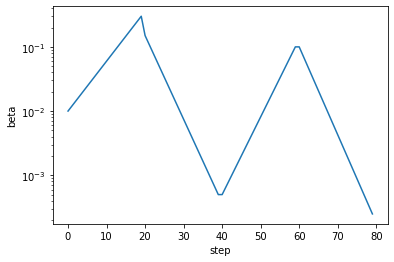

In [45]:
plt.plot(beta)
plt.yscale('log')
plt.ylabel("beta")
plt.xlabel("step")
plt.show()

In [37]:
beta_1 = np.concatenate((
one_annealing_cycle(1e-2,0.3,20),
one_annealing_cycle(0.15,0.1,20),
one_annealing_cycle(0.5e-3,0.1,20),
one_annealing_cycle(0.1,0.25e-3,20),
))

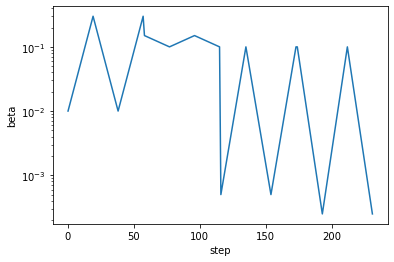

In [38]:
plt.plot(beta_1)
plt.yscale('log')
plt.ylabel("beta")
plt.xlabel("step")
plt.show()